In [16]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

plt.style.use("my_style.mplstyle")
def Am(Nmax,a=1,m=0):
    nvals = np.arange(1,Nmax+1)
    return sp.special.gamma(1+2*m) * np.array([[(a*n1)**m * (a*n2)**m / (a*(n1+n2))**(1+2*m) for n1 in nvals] for n2 in nvals])

def ubar(a,Nmax,m=0,alpha=0,U=None,S=None):
    if U is None or S is None:
        U,S,_ = np.linalg.svd(Am(Nmax,a,m)+alpha*np.eye(Nmax))
    nvals = np.arange(1,Nmax+1)
    us_an = lambda s: (a*nvals)**(-0.5+1j*s) / np.sqrt(2*np.pi)
    U_us = lambda s: U.T @ us_an(s)
    return lambda s: a * abs( sp.special.gamma(0.5+m+1j*s) )**2 * ( U @ np.diag(1./S) @ U_us(s) )


def A_m_eig_np(m:int, alpha:float, dim:int, a:float):
    A = np.zeros((dim, dim))
    for i in range(dim):
        A[i, i] = (a*(i+1))**(2*m)*sp.special.gamma(2*m+1)/(2*(i+1))**(2*m+1) + alpha
        for j in range(i+1, dim):
            A[i, j] = A[j, i] = a * ((i+1)*(j+1))**m *sp.special.gamma(2*m+1)/ (i+j+2)**(2*m+1)

    return np.linalg.eigh(A)

def mell_mat_np(s:float, m:float, a:float, A_eig, corr:np.ndarray, compute_err = True, cov:np.ndarray = None):
    dcorr = len(corr)
    dmat = A_eig[0].shape[0]

    u = np.array(a * (np.arange(1, dmat+1))**(-1/2 + s*1.0j), dtype = complex) / np.sqrt(2*np.pi) * np.abs(sp.special.gamma(m+0.5 + s*1.0j))**2.0 * a**2
    t = np.reshape(np.array((a * np.arange(1, dmat+1))**m), (dmat, 1))
    teigv = np.tile(t, (1, dmat)) * A_eig[1]
    ubar = teigv @ ((A_eig[1].T @ u)/A_eig[0])
    
    if compute_err:
        return corr.T @ ubar[:dcorr], np.sqrt(ubar[:dcorr].T @ cov @ ubar[:dcorr])
    else:
        return corr.T @ ubar[:dcorr], ubar[:dcorr]
Ninf = 1000; a0 = 1; alpha = 1e-12; m = 0
A1 = Am(Ninf,a0,m) + alpha * np.eye(Ninf)
U1,S1,V1 = np.linalg.svd(A1)
#S1, U1 = np.linalg.eigh(A1)
ubar1 = ubar(a0,Ninf,m,alpha,U1,S1)

nvals = np.arange(1,Ninf+1)
Cvals = np.exp(-0.3*nvals)
Cvals_nm = Cvals @ np.diag((a0*nvals)**m)

svals = np.linspace(0,25,101,endpoint=True)
tmax = 50
np.array([Cvals_nm[0:tmax] @ ubar1(20)[0:tmax]])[0]

(5.899521733089582e-25+2.102473965206641e-23j)

In [25]:
Ninf = 1000; a0 = 1; alpha = 1e-6; m = 0
A1 = Am(Ninf,a0,m) + alpha * np.eye(Ninf)
U1,S1,V1 = np.linalg.svd(A1)
#S1, U1 = np.linalg.eigh(A1)
Aeig = A_m_eig_np(m, alpha, Ninf, a0)

tmax = [40]
s = np.linspace(0, 25, 101)

cbar_matteo = np.zeros((len(tmax), len(s)), dtype = complex)
cbar_diego = np.zeros((len(tmax), len(s)), dtype = complex)
for si in range(len(s)):
    ubar1 = ubar(a0,Ninf,m,alpha,U1,S1)(s[si])
    for ti in range(len(tmax)):
        nvals = np.arange(1,tmax[ti]+1)
        Cvals = np.exp(-0.2*nvals)
        Cvals_nm = Cvals @ np.diag((a0*nvals)**m)
        cbar_matteo[ti, si] = Cvals_nm @ ubar1[0:int(tmax[ti])]
        cbar_diego[ti, si], _ = mell_mat_np(s[si], m, a0, Aeig, Cvals, compute_err = False)

Text(0.5, 1.0, '$m=2, \\alpha=10^{-12}, \\omega = 0.2, N_{\\infty} = 1000$')

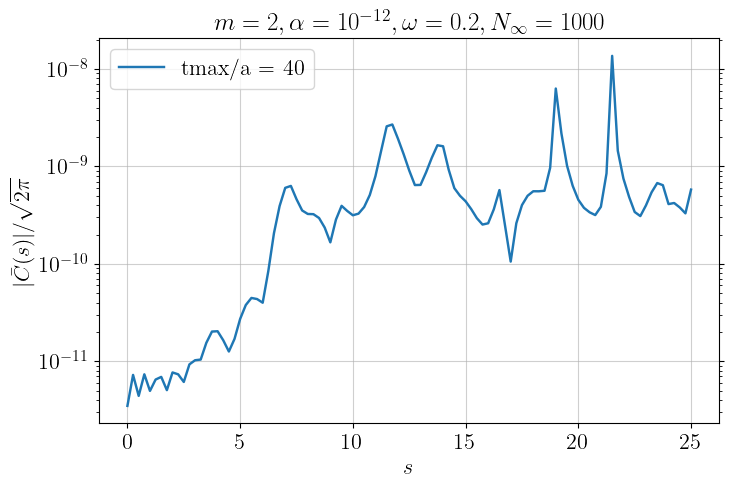

In [26]:
#plt.plot(s, np.abs(sp.special.gamma(0.5+m+1j*s)*(0.2)**(-0.5-m-1j*s)/np.sqrt(2*np.pi)), label = 'Analytic')
for ti in range(len(tmax)):
    line, = plt.plot(s, np.abs((cbar_matteo[ti] - cbar_diego[ti])/cbar_diego[ti]), label = f'tmax/a = {tmax[ti]}')
    #plt.plot(s, np.abs(cbar_diego[ti]), "o", color = line.get_color(), markersize = 4)
plt.semilogy()
plt.legend()
plt.xlabel(r'$s$')
plt.ylabel(r'$|\bar{C}(s)|/\sqrt{2\pi}$')
plt.title(r'$m=2, \alpha=10^{-12}, \omega = 0.2, N_{\infty} = 1000$')

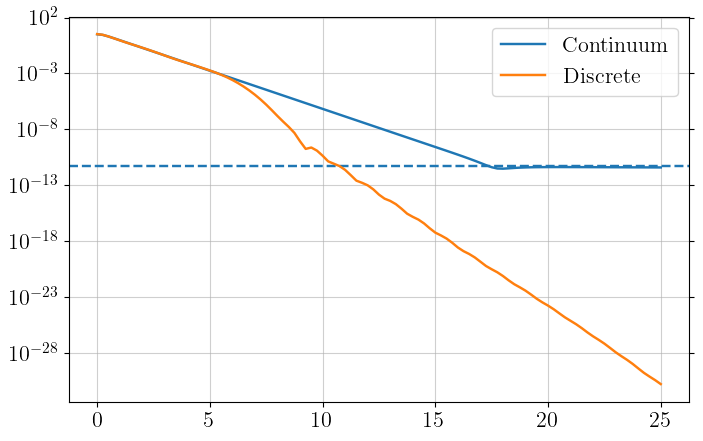

In [14]:
import numpy
import scipy
import matplotlib.pyplot as plt
import mpmath

plt.style.use("my_style.mplstyle")

def Am(Nmax,a=1,m=0):
    nvals = numpy.arange(1,Nmax+1)
    return scipy.special.gamma(1+2*m) * numpy.array([[(a*n1)**m * (a*n2)**m / (a*(n1+n2))**(1+2*m) for n1 in nvals] for n2 in nvals])

def ubar(a,Nmax,m=0,alpha=0,U=None,S=None):
    if U is None or S is None:
        U,S,_ = numpy.linalg.svd(Am(Nmax,a,m)+alpha*numpy.eye(Nmax))
    nvals = numpy.arange(1,Nmax+1)
    us_an = lambda s: (a*nvals)**(-0.5+1j*s) / numpy.sqrt(2*numpy.pi)
    U_us = lambda s: U.T @ us_an(s)
    return lambda s: a * abs( scipy.special.gamma(0.5+m+1j*s) )**2 * ( U @ numpy.diag(1./S) @ U_us(s) )

a = 0.065 # fm
w0 = 0.3
C0 = 1
C = lambda t: C0 * numpy.exp(-w0*t)
m = 0

Ninf = 1000; a0 = 1; alpha = 1e-8
A1 = Am(Ninf,a0,m) + alpha * numpy.eye(Ninf)
U1,S1,V1 = numpy.linalg.svd(A1)
ubar1 = ubar(a0,Ninf,m,alpha,U1,S1)

nvals = numpy.arange(1,Ninf+1)
Cvals = C(nvals)
Cvals_nm = Cvals @ numpy.diag((a0*nvals)**m)

svals = numpy.linspace(0,25,101,endpoint=True)
tmax = int(25/w0)
Cbartilde = numpy.array([Cvals_nm[0:tmax] @ ubar1(s)[0:tmax] * numpy.sqrt(2*numpy.pi) for s in svals])

def IncompleteMellinTransformExp(s,w0,tmax,m=0):
     if tmax == numpy.inf:
         return scipy.special.gamma(0.5+m+1j*s) * w0 ** (-0.5-m-1j*s)
     else:
         return complex(mpmath.gammainc(0.5+m+1j*s,0,w0*tmax,regularized=False)) * w0 ** (-0.5-m-1j*s)

def IncompleteGamma(S, wt):
    return complex(mpmath.gammainc(S,wt,mpmath.mp.inf,regularized=False))

def boundMellin(C,w0,tmax,m=0):
     return C(tmax) * w0**(-0.5-m) * numpy.exp(w0*tmax) * numpy.abs( IncompleteGamma(0.5+m,w0*tmax) )

Chat = numpy.array([ C0 * IncompleteMellinTransformExp(s,w0,tmax,m) for s in svals ])
bound_tmax = boundMellin(C,w0,tmax,m)

plt.figure()
plt.plot(svals,abs(Chat),color='C0',label='Continuum')
plt.axhline(y=bound_tmax,color='C0',linestyle='--')
plt.plot(svals,abs(Cbartilde),color='C1',label='Discrete')
plt.legend()
plt.yscale('log')
plt.draw()
plt.show()